In [35]:
# Define all of the required libraries for this analysis

import os

import pandas as pd
from pyspark.sql import SparkSession
import findspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col

findspark.init('C:\Program Files\Spark 3.1.2')

from sklearn.preprocessing import LabelEncoder
from sklearn import tree

In [36]:
# Define the directories for the files

symbolsFile = './StockData/all_symbols.txt'
dataDirectory = './StockData/full_history/'
# dataFiles is a list of all csv files within the directory/
symbols = []
dataFiles = []

with open(symbolsFile) as file_in:

    for line in file_in:
        value = line.rstrip()
        symbols.append(value)
        filename = dataDirectory + value + ".csv"
        dataFiles.append(filename)


In [37]:
# These are the columns for the csv files:

# [
#   date         object
#   volume        int64
#   open        float64
#   high        float64
#   low         float64
#   close       float64
#   adjclose    float64
# ]

dataSource = pd.read_csv(dataFiles[0], nrows=1)

dataSource.dtypes

date         object
volume        int64
open        float64
high        float64
low         float64
close       float64
adjclose    float64
dtype: object

In [38]:
stockID = 48
stockID2 = 278

# Define the source for all pandas calculations
dataSource = pd.read_csv(dataFiles[stockID]).sort_values(by=['date'])

# Second datasource for comparison
dataSource2 = pd.read_csv(dataFiles[stockID2]).sort_values(by=['date'])

In [39]:
# Calculate the price change (Difference between open and close price)

priceSwing = dataSource[['date', 'open' , 'close']]
priceSwing['Change'] = priceSwing['close'].sub(priceSwing['open'], axis = 0)

print(priceSwing)


            date       open      close    Change
6202  1995-09-14   2.277778   2.361111  0.083333
6201  1995-09-15   2.333333   2.361111  0.027778
6200  1995-09-18   2.333333   2.361111  0.027778
6199  1995-09-19   2.333333   2.333333  0.000000
6198  1995-09-20   2.333333   2.361111  0.027778
...          ...        ...        ...       ...
4     2020-06-26  28.580000  27.700001 -0.879999
3     2020-06-29  28.040001  28.370001  0.330000
2     2020-06-30  28.160000  28.650000  0.490000
1     2020-07-01  28.700001  28.150000 -0.550001
0     2020-07-02  28.879999  28.090000 -0.789999

[6203 rows x 4 columns]


C:\Users\ATBir\AppData\Local\Temp/ipykernel_30356/926917189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priceSwing['Change'] = priceSwing['close'].sub(priceSwing['open'], axis = 0)


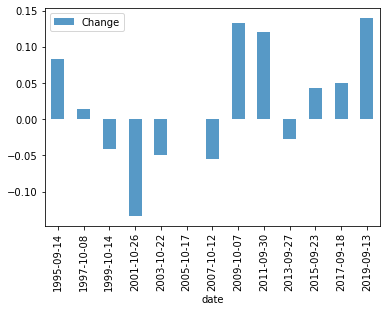

In [40]:
# Plot a bar chart of the change over time

# n represents the interval between measurements.
n = 500

plt = priceSwing.iloc[::n, :].plot(kind='bar',alpha=0.75, x='date', y='Change')
plt.tick_params(axis='x', rotation=90)



In [41]:
# No matter what two fields are analysed using Cross Tabulation, none of the data is useful with this analysis.

ctab = pd.crosstab(dataSource.high, dataSource.low)

print(ctab)

low        1.222222   1.250000   1.263889   1.270833   1.277778   1.284722   \
high                                                                          
1.277778           0          0          1          0          0          0   
1.305556           0          0          0          0          1          0   
1.312500           0          0          1          0          0          0   
1.319444           0          1          0          0          0          0   
1.333333           0          0          0          0          0          0   
...              ...        ...        ...        ...        ...        ...   
47.970001          0          0          0          0          0          0   
47.980000          0          0          0          0          0          0   
47.990002          0          0          0          0          0          0   
48.200001          0          0          0          0          0          0   
48.320000          0          0          0          

In [42]:
for index, row in dataSource.iterrows():
    print(row)

date        1995-09-14
volume        12915900
open          2.277778
high          2.388889
low           2.277778
close         2.361111
adjclose      2.361111
Name: 6202, dtype: object
date        1995-09-15
volume         3802500
open          2.333333
high          2.388889
low           2.305556
close         2.361111
adjclose      2.361111
Name: 6201, dtype: object
date        1995-09-18
volume         1345500
open          2.333333
high          2.416667
low           2.333333
close         2.361111
adjclose      2.361111
Name: 6200, dtype: object
date        1995-09-19
volume         1305000
open          2.333333
high          2.416667
low           2.333333
close         2.333333
adjclose      2.333333
Name: 6199, dtype: object
date        1995-09-20
volume          648900
open          2.333333
high          2.416667
low           2.333333
close         2.361111
adjclose      2.361111
Name: 6198, dtype: object
date        1995-09-21
volume         1063800
open          2.333

In [43]:
# Add information about the Day of the Week to the data source

# Date format '2020-05-07' ... YYYY MM dd


dataSourceDays = priceSwing
dataSourceDays['date']= pd.to_datetime(dataSource['date'])

dataSourceDays['week day number'] = dataSourceDays['date'].dt.dayofweek
dataSourceDays['week day'] = dataSourceDays['date'].dt.day_name()

# Attempt to find a correlation between the day of the week and the prices.

for i in dataSourceDays.index:
    madeProfit = dataSourceDays['Change'] > 0
    dataSourceDays['Profit'] = madeProfit

ctab = pd.crosstab(dataSourceDays['week day'], dataSourceDays['Profit'])

print(ctab)


C:\Users\ATBir\AppData\Local\Temp/ipykernel_30356/581881968.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSourceDays['date']= pd.to_datetime(dataSource['date'])
C:\Users\ATBir\AppData\Local\Temp/ipykernel_30356/581881968.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSourceDays['week day number'] = dataSourceDays['date'].dt.dayofweek
C:\Users\ATBir\AppData\Local\Temp/ipykernel_30356/581881968.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Profit     False  True
week day              
Friday       628   612
Monday       582   587
Thursday     650   599
Tuesday      652   625
Wednesday    630   638


In [44]:
# Join two stocks into a dataframe and compare

stock1 = symbols[stockID]
stock2 = symbols[stockID2]

ds1 = dataSource.rename(columns={'volume': stock1 + '_volume', 'open': stock1 + '_open', 'high': stock1 + '_high', 'low': stock1 + '_low', 'close': stock1 + '_close'})
ds2 = dataSource2.rename(columns={'volume': stock2 + '_volume', 'open': stock2 + '_open', 'high': stock2 + '_high', 'low': stock2 + '_low', 'close': stock2 + '_close'})

joined = pd.merge(ds1, ds2, on=['date'])

print(joined)

            date  ACGL_volume  ACGL_open  ACGL_high   ACGL_low  ACGL_close  \
0     2000-01-04        84600   1.263889   1.277778   1.263889    1.270833   
1     2000-01-05        80100   1.284722   1.388889   1.284722    1.388889   
2     2000-01-07       247500   1.375000   1.458333   1.375000    1.451389   
3     2000-01-10       455400   1.444444   1.513889   1.444444    1.500000   
4     2000-01-11       407700   1.486111   1.527778   1.458333    1.513889   
...          ...          ...        ...        ...        ...         ...   
3598  2020-06-26      4415300  28.580000  28.959999  27.639999   27.700001   
3599  2020-06-29      1438500  28.040001  28.570000  27.629999   28.370001   
3600  2020-06-30      2012500  28.160000  28.950001  28.160000   28.650000   
3601  2020-07-01      1279000  28.700001  29.030001  27.980000   28.150000   
3602  2020-07-02      1286100  28.879999  29.370001  28.000000   28.090000   

      adjclose_x  ALT_volume  ALT_open  ALT_high  ALT_low  ALT_

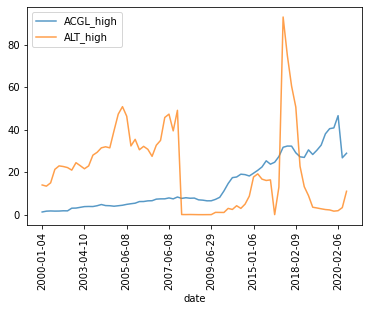

In [45]:
# Plot the highest price of each stock over time

# n represents the interval between measurements.
n = 50

plt = joined.iloc[::n, :].plot(kind='line',alpha=0.75, x='date', y= [stock1 + '_high', stock2 + '_high'])
plt.tick_params(axis='x', rotation=90)

In [46]:
# Get the top n stocks for a date

n = 10
searchDate = '2019-05-07'

symbolHeight = pd.DataFrame(columns=['Symbol', 'Highest'])

for filename in os.listdir(dataDirectory):
    try:
        if filename.endswith(".csv") or filename.endswith(".CSV"):
        
            # Get the name of each stock
            stockSymbol = os.path.splitext(filename)[0]

            # Get the data from the file
            df = pd.read_csv(dataDirectory + filename)


            # Print the current symbol with row count to show progress
            print(stockSymbol, ": ", df.shape[0], " rows")

            # Filter out all irrelevant data
            df = df.loc[df['date'] == searchDate]

            if (df.shape[0] >= 1):

                # Create a new row
                highest = df.iloc[0]['high']
                new_row = {'Symbol':stockSymbol, 'Highest':highest}
                # Add the row to the results
                symbolHeight = symbolHeight.append(new_row, ignore_index=True)

        else:
            continue
    
    except Exception:
        continue   
symbolHeight = symbolHeight.sort_values(by='Highest', ascending=False)    
symbolHeight = symbolHeight[0 : n]

print("DONE!")


A :  1  rows
AA :  1  rows
AAAU :  474  rows
AACG :  333  rows
AADR :  2203  rows
AAL :  3717  rows
AAMC :  1796  rows
AAME :  9221  rows
AAN :  7785  rows
AAOI :  1695  rows
AAON :  6913  rows
AAP :  4680  rows
AAPL :  9973  rows
AAT :  2383  rows
AAU :  3658  rows
AAWW :  3680  rows
AAXJ :  2989  rows
AAXN :  1  rows
AB :  8120  rows
ABB :  4840  rows
ABBV :  1889  rows
ABC :  6357  rows
ABCB :  6383  rows
ABEO :  4051  rows
ABEQ :  114  rows
ABEV :  4224  rows
ABG :  4604  rows
ABIO :  2321  rows
ABM :  10118  rows
ABMD :  1  rows
ABR :  4088  rows
ABT :  10162  rows
ABTX :  1192  rows
ABUS :  3067  rows
AC :  1159  rows
ACA :  417  rows
ACAD :  4042  rows
ACAM :  194  rows
ACAMU :  1  rows
ACAMW :  1  rows
ACB :  2044  rows
ACBI :  1166  rows
ACC :  3990  rows
ACCO :  3745  rows
ACEL :  327  rows
ACER :  2746  rows
ACES :  504  rows
ACGL :  6203  rows
ACGLO :  722  rows
ACGLP :  950  rows
ACH :  4654  rows
ACHC :  1  rows
ACHV :  3399  rows
ACI :  3220  rows
ACIA :  1033  rows
ACIO

<AxesSubplot:xlabel='Symbol'>

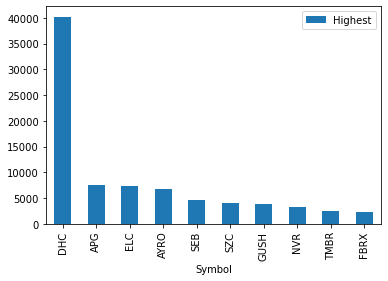

In [47]:
# Graph the highest values for they symbols

symbolHeight.plot.bar(x='Symbol',y='Highest')

In [50]:
# Predict whether the stock will close with a profit based on the change throughout the day (Would the close be higher than the open price?)

# Define the data
spark = SparkSession.builder.appName("SparkLab").getOrCreate()
dataSource = pd.read_csv(dataFiles[stockID]).sort_values(by=['date'])

# Add the profit to the table
for i in dataSource.index:
    dataSource['Profit'] = dataSource['close'] > dataSource['open']




# Prediction for profits using DecisionTree classification model

leDate = LabelEncoder()
dataSource['date_number'] = leDate.fit_transform(dataSource['date']) # Transform the date into a numerical value
leOpen = LabelEncoder()
dataSource['open_number'] = leOpen.fit_transform(dataSource['open']) # Transform the open into an integer value
leHigh = LabelEncoder()
dataSource['high_number'] = leHigh.fit_transform(dataSource['high']) # Transform the high into an integer value
leLow = LabelEncoder()
dataSource['low_number'] = leLow.fit_transform(dataSource['low']) # Transform the low into an integer value


# Split the data into training and test data
trainingDataFull = dataSource.sample(frac = 0.7)
testDataFull = dataSource.drop(trainingDataFull.index)

# Prepare the training and test data and targets

# Set the target data to the profit values
testTarget = testDataFull['Profit']
trainingTarget = trainingDataFull['Profit']
# Remove unnecessary data 
trainingData = trainingDataFull.drop(['date', 'close', 'adjclose', 'open', 'high', 'low', 'Profit'], axis='columns') 
testData = testDataFull.drop(['date', 'close', 'adjclose', 'open', 'high', 'low', 'Profit'], axis='columns') 


# Train the classifier

model = tree.DecisionTreeClassifier()
model.fit(trainingData, trainingTarget)

# Get a prediction for each entry in the testData
predictions = model.predict(testData)

spark.stop()

In [51]:
# Compare the prediction made to the testData

testDataFull['Prediction'] = predictions

print(testDataFull[['date', 'Prediction', 'Profit']])

# Compare values using Cross Tabulation
ctab = pd.crosstab(testDataFull['Profit'], testDataFull['Prediction'])

print(ctab)

total = testDataFull.count()['Profit']
correct = testDataFull[testDataFull['Profit'] == testDataFull['Prediction']].count()['Prediction']

accuracy = (correct/total) * 100


print('%d correct out of %d predictions.' % (correct, total))
print('Accuracy of the current model is %d percent' % accuracy)


            date  Prediction  Profit
6200  1995-09-18       False    True
6197  1995-09-21        True    True
6194  1995-09-26        True   False
6191  1995-09-29       False    True
6188  1995-10-04        True    True
...          ...         ...     ...
11    2020-06-17        True   False
10    2020-06-18        True    True
5     2020-06-25        True    True
3     2020-06-29       False    True
1     2020-07-01       False   False

[1861 rows x 3 columns]
Prediction  False  True
Profit                 
False         602   384
True          319   556
1158 correct out of 1861 predictions.
Accuracy of the current model is 62 percent
